# Evaluation of the polymorphic Gompertzian model on in vivo data

This code contains fitting of the polymorphic Gompertzian model to in vivo data of patients tumor dynamics, comparisson with fits of classical models of cancer growth and evaluation of the fit errors. 

In [1]:
#Import required packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import ticker
from gekko import GEKKO
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import stats

In [2]:
#Load data
os.chdir('/Users/Arina/Desktop/Master Thesis/In vivo data')

study1 = pd.read_excel('Study_1_1.xlsx')
study2 = pd.read_excel('Study_2_1.xlsx')
study3 = pd.read_excel('Study_3_1.xlsx')
study4 = pd.read_excel('Study_4_1.xlsx')
study5 = pd.read_excel('Study_5_1.xlsx')


In [3]:
# Filter data in the same way it was done in Narmin's paper
# Keep only patients with at least 6 time points
def FilterData(data):
    Data_filtered = pd.DataFrame(columns = data.columns)
    PatientIDs = list(data['USUBJID'].unique())

    for ID in PatientIDs:
        FilteredData = data.loc[data['USUBJID'] == ID]
        temp = FilteredData['TRLINKID'].unique()
        temp = [i for i in temp if not str(i) == 'nan']
        temp = [i for i in temp if not '-NT' in str(i)]
    
        if  'INV-T001' in temp :
            tumorFiltered_Data = FilteredData.loc[FilteredData['TRLINKID'] == 'INV-T001']
            tumorFiltered_Data.dropna(subset = ['TRDY'])#, inplace = True)
        
            tumorFiltered_Data = tumorFiltered_Data[tumorFiltered_Data['TRTESTCD'] == 'LDIAM']

            VisitsN = len(tumorFiltered_Data)
            if VisitsN >= 6:
                Data_filtered = Data_filtered.append(tumorFiltered_Data)
            
            # Change string elements in meassurement column to 0 
            str_elements = Data_filtered['TRORRES'].apply(type) == str
            Data_filtered.loc[str_elements, 'TRORRES'] = 0
                
    return Data_filtered
    

In [4]:
Study1_filtered = FilterData(study1)
Study2_filtered = FilterData(study2)
Study3_filtered = FilterData(study3)
Study4_filtered = FilterData(study4)
Study5_filtered = FilterData(study5)

In [5]:
#Make arm reflect the treatment used
Study1_filtered['ARM'] = 'MPDL3280A'
Study2_filtered['ARM'] = Study2_filtered['TRT01P']
Study3_filtered['ARM'] = 'MPDL3280A'
Study4_filtered['ARM'] = Study4_filtered['TRT01A']

In [6]:
# Combine meassurments from all studies 
Data_full = np.zeros((590, 20))
tpoints_full = np.zeros((590, 20))

i = 0
for study in [Study1_filtered, Study2_filtered, Study3_filtered, Study4_filtered]:
    for ID in study['USUBJID'].unique():
        PatientData = study[study['USUBJID'] == ID]
        dimension = np.array(PatientData['TRORRES'])
        volume = 0.52 * dimension*dimension*dimension
        time = np.array(PatientData['TRDY'])
        volume = [x for _,x in sorted(zip(time,volume))]
        time = sorted(time) 
            
        Data_full[i, :len(volume)] = volume
        Data_full[i, len(volume):] = [None]*(20 - len(volume)) 
        tpoints_full[i, :len(time)] = time
        tpoints_full[i, len(time):] = [None]*(20 - len(time)) 
        
        i = i + 1

# Optimization problem 

In [7]:
# Function fits the model to tumor dynamics data of the patient
def FindIndParamsVivo(days, data, rho_init, gamma_init, K_init, K_ub, p_val, opt_init_prop = True):
    # define GEKKO model
    m = GEKKO(remote = False)
    
    m.time = days
    Exp_data = m.Param(data)

    rho = m.FV(value = rho_init, lb= 0)
    gamma = m.FV(value= gamma_init, lb = 0)
    if K_ub == -1:
        K = m.FV(value = K_init, lb = 0.9*max(data[:]))
    else:
        K = m.FV(value = K_init, lb = 0.9*max(data[:]),  ub = K_ub*max(data))
        
    rho.STATUS = 1
    gamma.STATUS = 1
    K.STATUS = 1 
    C = 1
    
    S0 = p_val*data[0]
    R0 = (1 - p_val)*data[0]

    S = m.Var(value = S0, lb = 0)
    R = m.Var(value = R0, lb = 0)
    
    # equations
    m.Equation(S.dt() == rho*(1-gamma*C)*m.log(K/(S+R))*S)
    m.Equation(R.dt() == rho*m.log(K/(S+R))*R)
    
    # objective
    m.Minimize(((Exp_data - (S+R)))**2)

    # application options 
    m.options.IMODE = 5 # dynamic estimation
    m.options.NODES = 5   # collocation nodes
    m.options.EV_TYPE = 2 # linear error (2 for squared)
    m.options.MAX_ITER = 1000
    
    m.solve(disp = False)
    
    error = m.options.OBJFCNVAL
    
    return np.array(S), np.array(R), error, K.value[0], rho.value[0], gamma.value[0]



In [8]:
#Function calculates solutions for different initial proportions of sensitive cells
# and returns the best fit
def FindBestSolInProps(Data, time, props, rho_init, K_init_val, Kub, gamma_init):
    
    volume = Data[~np.isnan(Data)]
    time = time[~np.isnan(Data)]
    K_init = max(volume)*K_init_val
    
    resS = np.zeros(20)
    resR = np.zeros(20)
    resK = 0
    resrho = 0
    resgamma = 0
    resprops = 0
    
    
    err_min = -1
    for p_val in props:
        try:
            S, R, error, K, rho, gamma = FindIndParamsVivo(time, volume, rho_init,
                                                           gamma_init, K_init, Kub, 
                                                           p_val)
            err = mean_squared_error(R+S, volume)
            if (err < err_min)|(err_min == -1) :
                resprops = p_val
                resS[:len(time)] = S
                resR[:len(time)] = R
                resK = K
                resrho = rho
                resgamma = gamma
                
                resS[len(time):] = [None] * (20 - len(time))
                resR[len(time):] = [None] * (20 - len(time))              

                err_min = err   
        except:
            pass
    return resS, resR, resK, resrho, resgamma, resprops, err_min

In [9]:
S_full = np.zeros((590, 20))
R_full = np.zeros((590, 20))
K_full = np.zeros((590))
rho_full = np.zeros((590))
gamma_full = np.zeros((590))
props_full = np.zeros((590))

In [10]:
# Obtain the model's fit for all patients

for k in range(0, 590):
    err_min = -1
    for Kub in [-1, 10, 100]:
        
        props = [0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65,
             0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99, 1]
        rho_init = 0.001
        gamma_init = 2
        K_init =  10

        resS, resR, resK, resrho, resgamma, resprops, err = FindBestSolInProps(Data_full[k],
                                                                              tpoints_full[k], props, rho_init, K_init, Kub, gamma_init)
        if (err < err_min)|(err_min == -1):
            err_min = err
            S_full[k] = resS
            R_full[k] = resR
            K_full[k] = resK
            rho_full[k] = resrho
            gamma_full[k] = resgamma
            props_full[k] = resprops  
    print(k)  


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [12]:
#Function to plot dynamics of the data and the model fit 
def PlotSolutions(indxs, Data_full, tpoints_full, S_full, R_full, plotSR = False):
    
    plt.figure(figsize = (21, 50))

    k = 1
    for i in indxs:
        volume = Data_full[i, ~np.isnan(Data_full[i])]
        time = tpoints_full[i, ~np.isnan(tpoints_full[i])]

        ax = plt.subplot(10, 5, k)
        ax.plot(time, volume, 'x', color = 'darkorange', label ='Messured')
        ax.plot(tpoints_full[i], S_full[i]+R_full[i], label = 'Predicted N')
        if plotSR:
            ax.plot(tpoints_full[i], R_full[i], label = 'Predicted R')
            ax.plot(tpoints_full[i], S_full[i], label = 'Predicted S')
            
        formatter = ticker.ScalarFormatter(useMathText=True)
        formatter.set_scientific(True) 
        formatter.set_powerlimits((-1,1)) 
        ax.yaxis.set_major_formatter(formatter) 
        ax.legend()
        ax.set_xlabel('Time(days)')
        k = k+1
    
    plt.show()

In [16]:
# exclude 3 patients, for which the solution was not found

#to_exclude = np.where(K_full == 0)
to_exclude = [242, 483, 562]

Data_full = Data_full[[i for i in range(590) if i not in to_exclude]]
tpoints_full = tpoints_full[[i for i in range(590) if i not in to_exclude]]
S_full = S_full[[i for i in range(590) if i not in to_exclude]]
R_full = R_full[[i for i in range(590) if i not in to_exclude]]
rho_full = rho_full[[i for i in range(590) if i not in to_exclude]]
gamma_full = gamma_full[[i for i in range(590) if i not in to_exclude]]
props_full = props_full[[i for i in range(590) if i not in to_exclude]]
K_full = K_full[[i for i in range(590) if i not in to_exclude]]

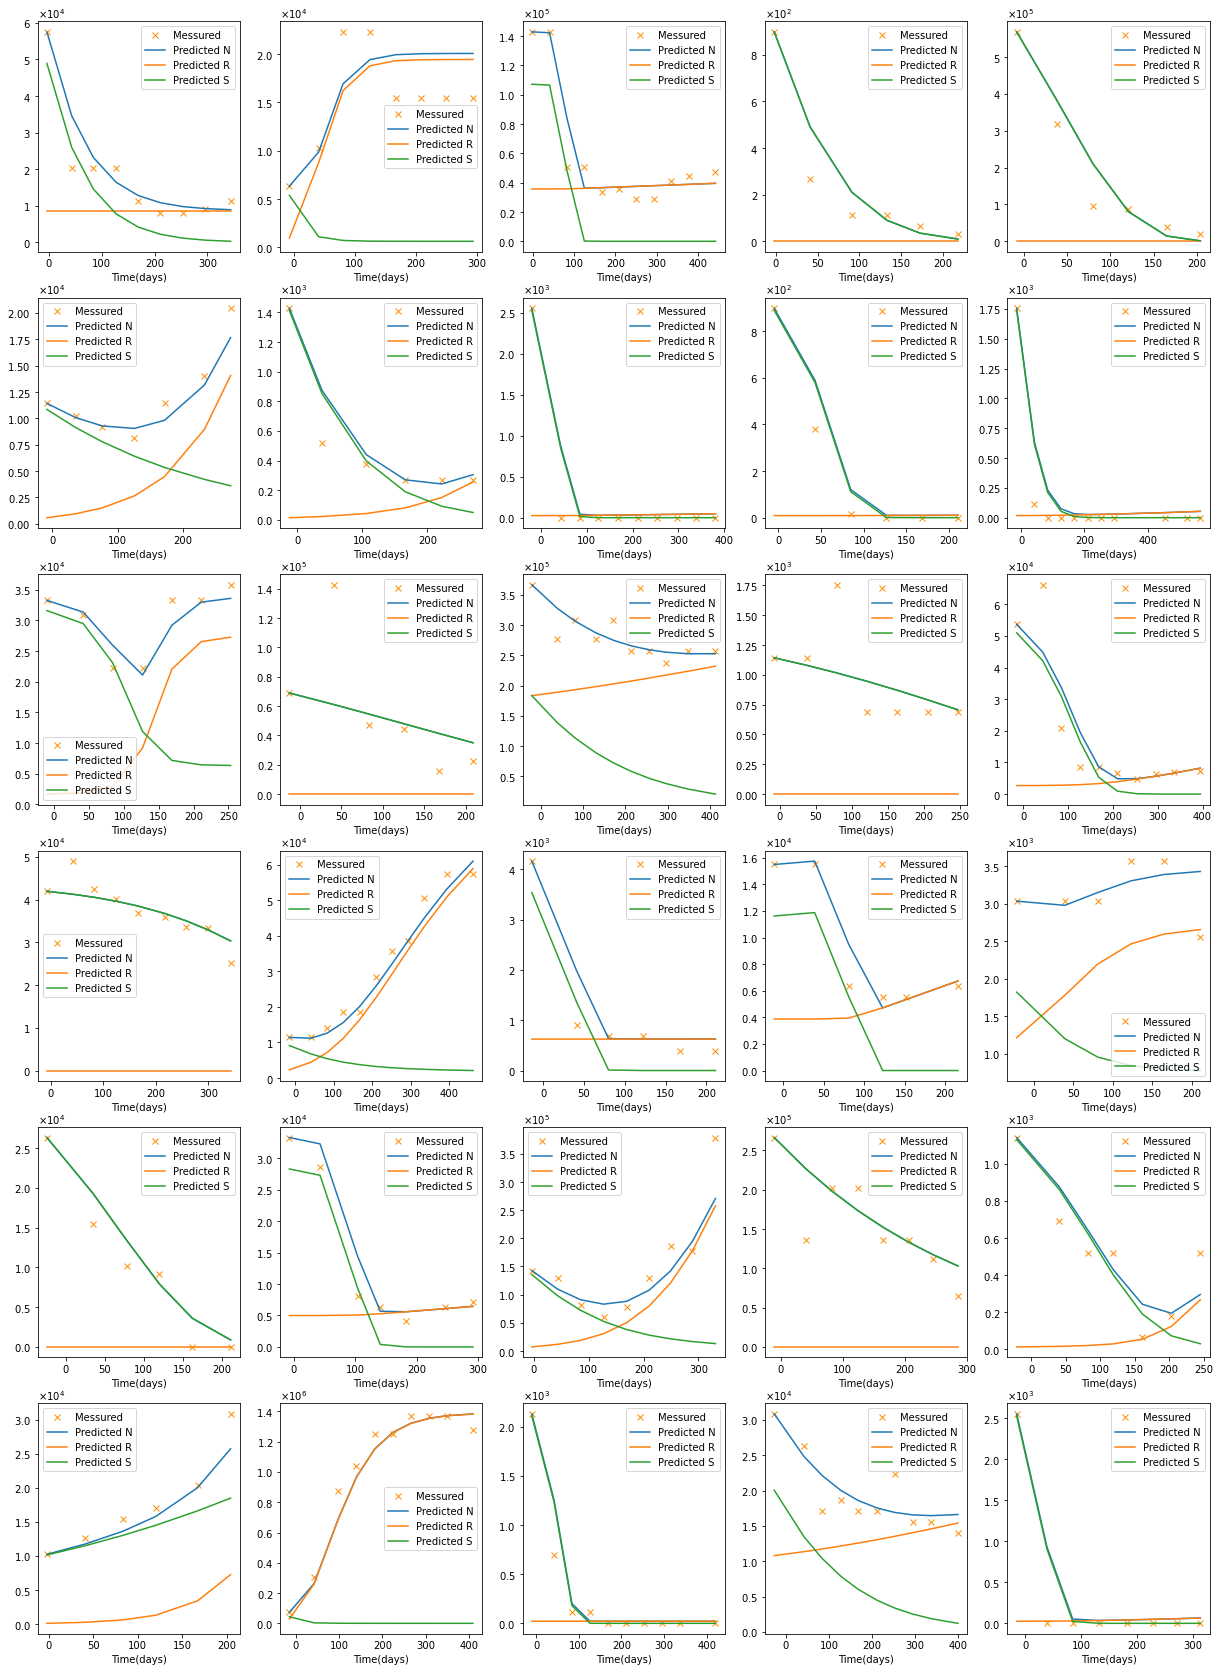

In [17]:
PlotSolutions(np.arange(0,30), Data_full, tpoints_full, S_full, R_full, plotSR = True)

# Analyze results statistically

In [18]:
#Normalized mean squared error
def nmse(x_mes, x_pred):
    x_pred = x_pred[~np.isnan(x_pred)]
    x_mes = x_mes[~np.isnan(x_mes)]
    if len(x_pred) == len(x_mes):
        err = sum(((x_mes-x_pred)/max(x_mes))**2)/len(x_mes)
        return err
    else:
        return 0

In [19]:
#Create an array with drug used for each patient
Drugs = np.zeros(590)
k = 0
for StudyN in range(1,5):
    study = eval('Study'+ str(StudyN) + '_filtered')
    
    for ID in study['USUBJID'].unique():
        PatientData = study[study['USUBJID'] == ID]
        
        if PatientData['ARM'].unique()[0] == 'MPDL3280A':
            Drugs[k] = 1
        else:
            Drugs[k] = 2
        k = k+1
                   
Drugs = Drugs[[i for i in range(590) if i not in to_exclude]]

In [23]:
# Classify patinets into groups based on trend
def DetectTrend(Data_full, tpoints):
    trend = ["" for x in range(587)]
    for i in range(0, 587):
        volume = Data_full[i, ~np.isnan(Data_full[i])]
        time = tpoints[i, ~np.isnan(Data_full[i])]
        dif = np.diff(volume)
        
        if all(dif >= 0) | ((dif[0] > 0) & (sum(dif[dif>0]) > 2* sum(abs(dif[dif<0])))):
            trend[i] = 'Monotonic growth'
        elif all(dif <= 0) | ((dif[0] < 0) & (2*sum(dif[dif>0]) < sum(abs(dif[dif<0])))):
            trend[i] = 'Monotonic decline'
        elif (dif[np.where(dif !=0)[0][0]] > 0) & (any(dif[np.where(dif !=0)[0]] < 0)) & (volume[-1]<volume[0]):
            trend[i] = 'Delayed response'
        elif any(np.diff(np.sign(dif[(abs(dif/(max(volume)-min(volume)))>0.1)])) == 2) & all(np.diff(np.sign(dif[(abs(dif/(max(volume)-min(volume)))>0.1)])) != -2):
            trend[i] = 'U-shape'
        else:
            trend[i] = 'Fluctuate'
    return trend   
        

In [24]:
trend_full = DetectTrend(Data_full, tpoints_full)

In [25]:
#trend_full = DetectTrend(Data_full, tpoints_full)    

indexesDR = [i for i,trend_full in enumerate(trend_full) if trend_full == 'Delayed response']
indexesU = [i for i,trend_full in enumerate(trend_full) if trend_full == 'U-shape']
indexesMG = [i for i,trend_full in enumerate(trend_full) if trend_full == 'Monotonic growth']
indexesMD = [i for i,trend_full in enumerate(trend_full) if trend_full == 'Monotonic decline']
indexesF = [i for i,trend_full in enumerate(trend_full) if trend_full == 'Fluctuate']

In [26]:
# Number of patients in each trend category
print('Delayed response: ' + str(len(indexesDR)))
print('U-shape: ' + str(len(indexesU)))
print('Growth: ' + str(len(indexesMG)))
print('Decline: ' + str(len(indexesMD)))
print('Fluctuate: ' + str(len(indexesF)))

Delayed response: 65
U-shape: 81
Growth: 98
Decline: 239
Fluctuate: 104


In [27]:
#Calculate errors
nMSE = np.zeros(587)
MSE = np.zeros(587)
MAE = np.zeros(587)
for i in range(587):
    nMSE[i] = nmse(Data_full[i, ~np.isnan(Data_full[i])], (S_full[i] + R_full[i])[~np.isnan(Data_full[i])])
    MSE[i] = mean_squared_error(Data_full[i, ~np.isnan(Data_full[i])], (S_full[i] + R_full[i])[~np.isnan(Data_full[i])])
    MAE[i] = mean_absolute_error(Data_full[i, ~np.isnan(Data_full[i])], (S_full[i] + R_full[i])[~np.isnan(Data_full[i])])
    
Errors = nMSE    
Errors = np.nan_to_num(Errors)

# Visualizations 

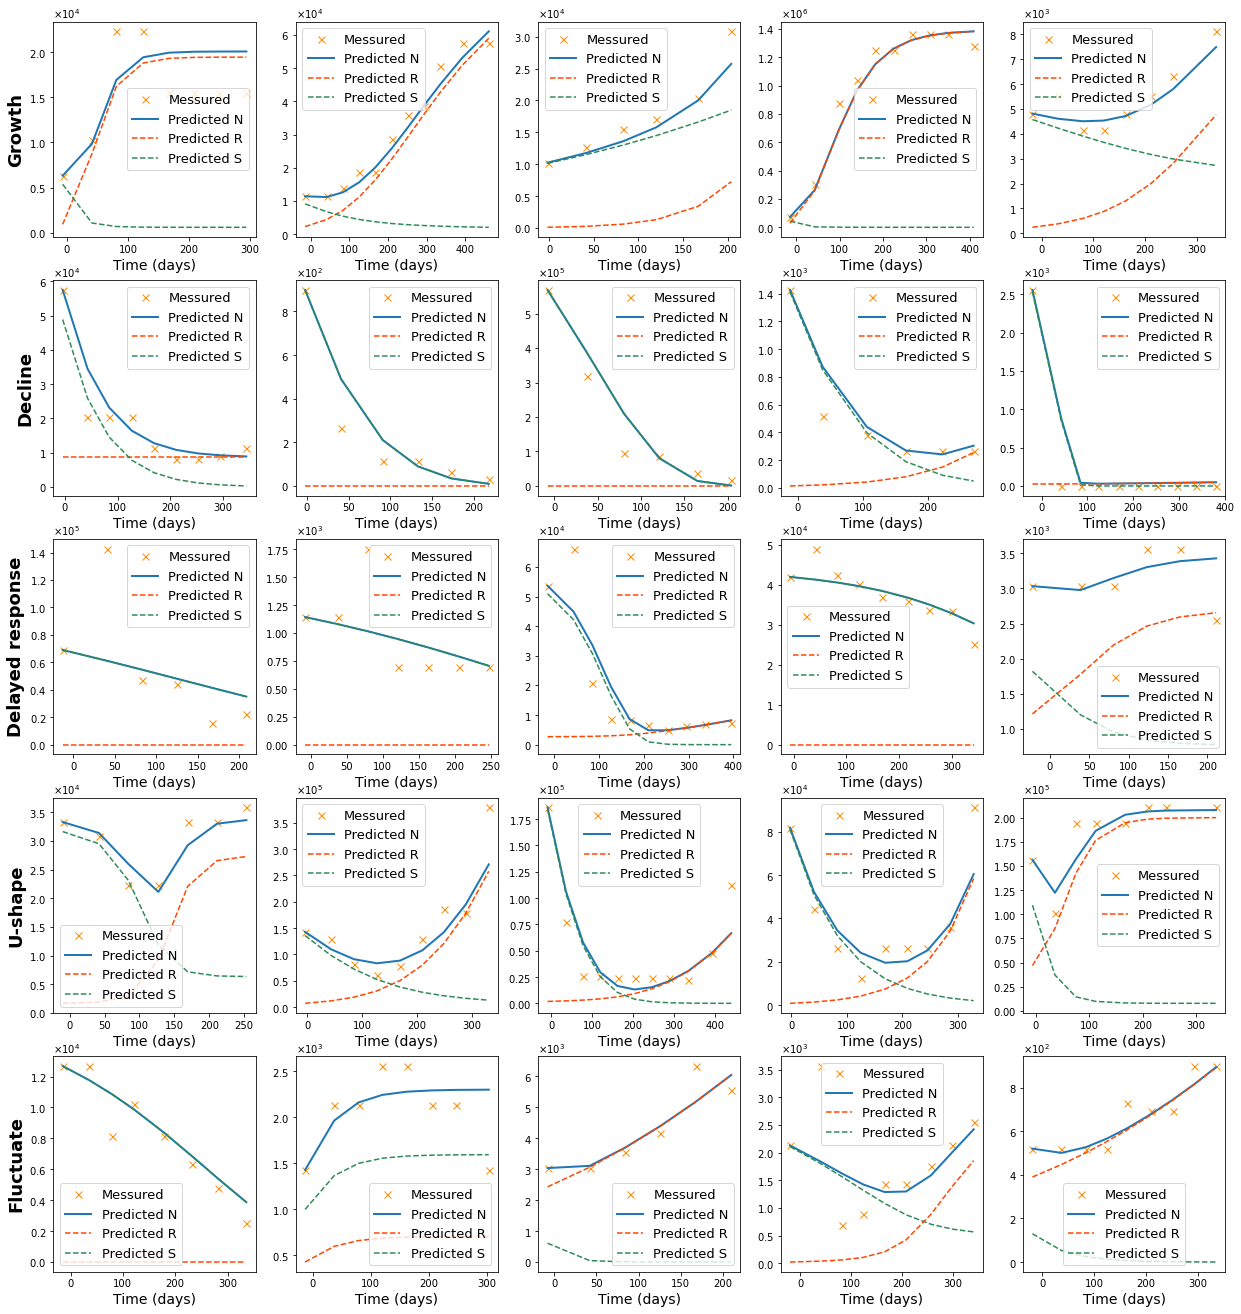

In [28]:
#Visualize dynamics across trend groups
indxs = [indexesMG[:5], indexesMD[:5], indexesDR[:5], indexesU[1:6], indexesF[10:15]]
indxs = np.array(indxs).flatten()

plt.figure(figsize = (21, 23))
plotSR = True

k = 1
for i in indxs:
    volume = Data_full[i, ~np.isnan(Data_full[i])]
    time = tpoints_full[i, ~np.isnan(tpoints_full[i])]
    
    ax = plt.subplot(5, 5, k)
    ax.plot(time, volume, 'x', markersize = 7, color = 'darkorange', label ='Messured')
    ax.plot(tpoints_full[i], S_full[i]+R_full[i], linewidth = 2, label = 'Predicted N')
    if plotSR:
        ax.plot(tpoints_full[i], R_full[i], color = 'orangered', linestyle = '--', label = 'Predicted R')
        ax.plot(tpoints_full[i], S_full[i], color = 'seagreen', linestyle = '--', label = 'Predicted S')
        
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True) 
    formatter.set_powerlimits((-1,1)) 
    ax.yaxis.set_major_formatter(formatter) 
        
    ax.legend(fontsize = 13)
    ax.set_xlabel('Time (days)', size = 14)
    #ax.set_ylabel('Tumor volume ($mm^3$)')
    classification = ['Growth', 'Decline', 'Delayed response', 'U-shape', 'Fluctuate']
    if ((k-1)%5 == 0):
        ax.set_ylabel(classification[int((k-1)/5)], weight = 'bold', size = 18)
    k = k+1
    
plt.show()


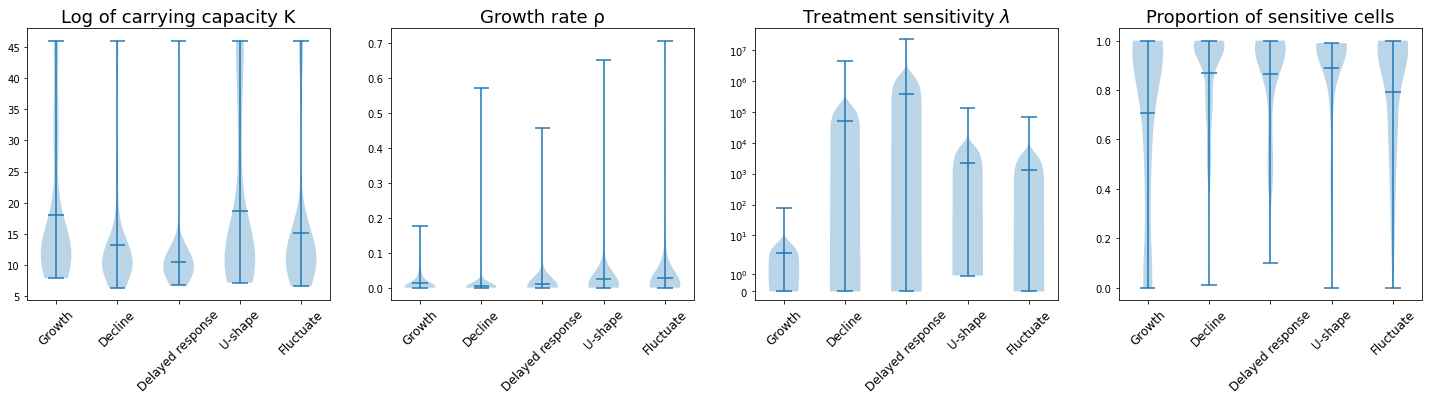

In [29]:
#Distribution of the model's parameters across trend categories
plt.figure(figsize=(25, 5))

ax1 = plt.subplot(1,4,1)
ax1.violinplot([np.log(K_full[indexesMG]), np.log(K_full[indexesMD]),
                np.log(K_full[indexesDR]), np.log(K_full[indexesU]),
                np.log(K_full[indexesF])][::-1],
              positions =[5,4,3,2,1],vert=True,showmeans=True)
ax1.set_xticks([1,2,3,4,5]) 
ax1.set_xticklabels(['Growth', 'Decline', 'Delayed response',
                     'U-shape', 'Fluctuate'], fontsize=12, rotation = 45)

ax1.set_title('Log of carrying capacity K', size = 18)

ax2 = plt.subplot(1,4,2)
ax2.violinplot([rho_full[indexesMG],rho_full[indexesMD],rho_full[indexesDR],rho_full[indexesU],rho_full[indexesF]][::-1],
              positions =[5,4,3,2,1],vert=True,showmeans=True)
ax2.set_xticks([1,2,3,4,5]) 
ax2.set_xticklabels(['Growth', 'Decline', 'Delayed response',
                     'U-shape', 'Fluctuate'], fontsize=12, rotation = 45)

ax2.set_title('Growth rate ' + chr(961), size =18)

ax3 = plt.subplot(1,4,3)
ax3.violinplot([gamma_full[indexesMG],gamma_full[indexesMD],gamma_full[indexesDR],gamma_full[indexesU],gamma_full[indexesF]][::-1],
              positions =[5,4,3,2,1],vert=True,showmeans=True)
ax3.set_xticks([1,2,3,4,5]) 
ax3.set_xticklabels(['Growth', 'Decline', 'Delayed response',
                     'U-shape', 'Fluctuate'], fontsize=12, rotation = 45)
ax3.set_yscale('symlog')
ax3.set_ylim([-0.5, 5*10**7])
ax3.set_title('Treatment sensitivity $\lambda$', size =18)

ax4 = plt.subplot(1,4,4)
ax4.violinplot([props_full[indexesMG],props_full[indexesMD],props_full[indexesDR],props_full[indexesU],props_full[indexesF]][::-1],
              positions =[5,4,3,2,1],vert=True,showmeans=True)
ax4.set_xticks([1,2,3,4,5]) 
ax4.set_xticklabels(['Growth', 'Decline', 'Delayed response',
                     'U-shape', 'Fluctuate'], fontsize=12, rotation = 45)
ax4.set_title('Proportion of sensitive cells', size =18)

plt.show()

# T-tests

In [30]:
# Compare K values in different trend categories
stats.ttest_ind(K_full[indexesU], K_full[indexesDR],
                equal_var = False, alternative = "greater")

Ttest_indResult(statistic=3.0141581810413625, pvalue=0.00161723347753931)

In [31]:
# Compare rho values in different trend categories
stats.ttest_ind(rho_full[indexesU], rho_full[indexesDR],
                equal_var = False, alternative = "greater")

Ttest_indResult(statistic=1.2151119160073665, pvalue=0.1131704282416244)

In [32]:
# Compare gamma values in different trend categories
stats.ttest_ind(gamma_full[indexesMG], gamma_full[indexesDR],
                equal_var = False, alternative = "less")

Ttest_indResult(statistic=-1.1087178958657111, pvalue=0.13585048121736737)

In [33]:
# Compare initial proportion values in different trend categories
stats.ttest_ind(props_full[indexesU], props_full[indexesDR],
                equal_var = False, alternative = "greater")

Ttest_indResult(statistic=0.7806504358972197, pvalue=0.21817665397106406)

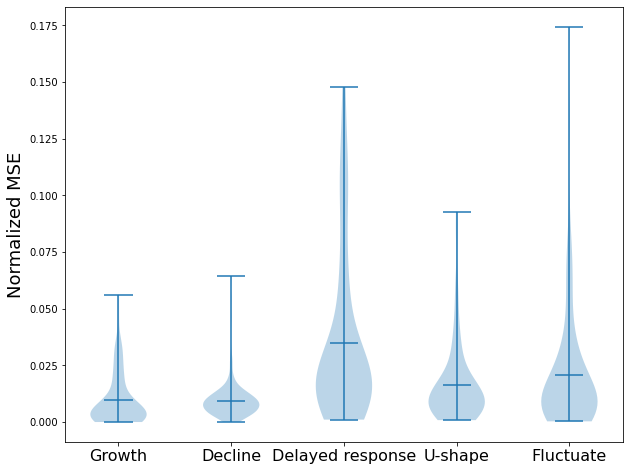

In [34]:
# Normalized MSE of the model's fits across five trend categories
plt.figure(figsize=(10, 8))
plt.violinplot([Errors[indexesMG], Errors[indexesMD], Errors[indexesDR],
                Errors[indexesU], Errors[indexesF]][::-1],
               positions =[5,4,3,2,1],vert=True,showmeans=True)
plt.xticks([1,2,3,4,5], ['Growth', 'Decline', 'Delayed response',
                     'U-shape', 'Fluctuate'], fontsize=16)
plt.ylabel('Normalized MSE', size = 18)

plt.show()

In [35]:
stats.mannwhitneyu(Errors[indexesMG], Errors[indexesMD]) #, alternative = "greater")

MannwhitneyuResult(statistic=9239.0, pvalue=0.0023431578863248002)

In [36]:
#Check statistical significance of differences between categories
stats.ttest_ind(Errors[indexesDR], Errors[indexesU],
                equal_var = False, alternative = "greater")

Ttest_indResult(statistic=3.7386644837614855, pvalue=0.00016588466664569574)

In [37]:
stats.ttest_ind(Errors[indexesU], Errors[indexesDR], alternative = "less")

Ttest_indResult(statistic=-4.012825030683989, pvalue=4.804716453418267e-05)

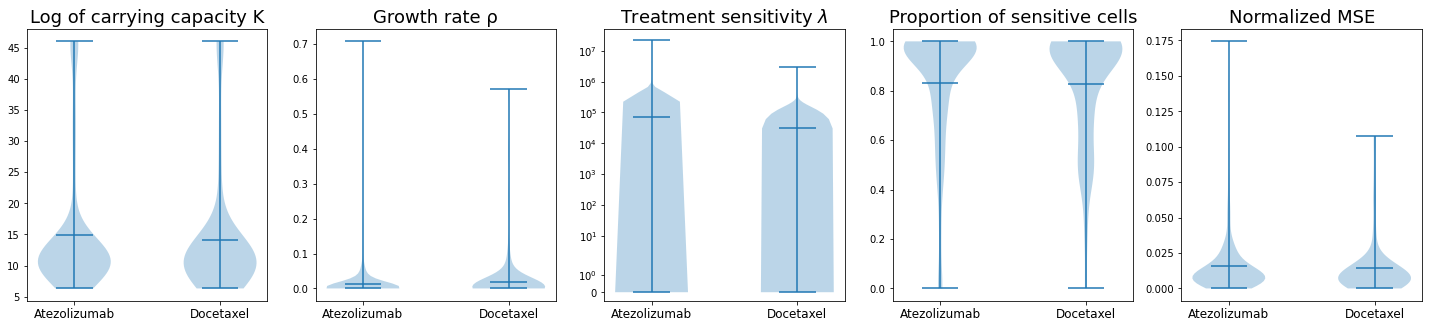

In [38]:
# Difference in parameter values and fitting errors between drug groups
plt.figure(figsize=(25, 5)) 

ax1 = plt.subplot(1,5,1)
ax1.violinplot([np.log(K_full[Drugs == 1]), np.log(K_full[Drugs == 2])][::-1],
               positions =[2,1], vert = True, showmeans = True)
ax1.set_xticks([1,2]) 
ax1.set_xticklabels(['Atezolizumab', 'Docetaxel'], fontsize=12)
ax1.set_title('Log of carrying capacity K', size = 18)

ax2 = plt.subplot(1,5,2)
ax2.violinplot([rho_full[Drugs == 1], rho_full[Drugs == 2]][::-1],
               positions =[2,1], vert = True, showmeans = True)
ax2.set_xticks([1,2]) 
ax2.set_xticklabels(['Atezolizumab', 'Docetaxel'], fontsize=12)
ax2.set_title('Growth rate ' + chr(961), size =18)

ax3 = plt.subplot(1,5,3)
ax3.violinplot([gamma_full[Drugs == 1], gamma_full[Drugs == 2]][::-1],
               positions =[2,1], vert = True, showmeans = True)
ax3.set_yscale('symlog')
ax3.set_ylim([-0.5, 5*10**7])
ax3.set_xticks([1,2]) 
ax3.set_xticklabels(['Atezolizumab', 'Docetaxel'], fontsize=12)
ax3.set_title('Treatment sensitivity $\lambda$', size =18)

ax4 = plt.subplot(1,5,4)
ax4.violinplot([props_full[Drugs == 1], props_full[Drugs == 2]][::-1],
               positions =[2,1], vert = True, showmeans = True)
ax4.set_xticks([1,2]) 
ax4.set_xticklabels(['Atezolizumab', 'Docetaxel'], fontsize=12)
ax4.set_title('Proportion of sensitive cells', size =18)

ax5 = plt.subplot(1,5,5)
ax5.violinplot([Errors[Drugs == 1], Errors[Drugs == 2]][::-1], positions =[2,1],
               vert = True, showmeans = True)
ax5.set_xticks([1,2]) 
ax5.set_xticklabels(['Atezolizumab', 'Docetaxel'], fontsize=12)
ax5.set_title('Normalized MSE', size =18)
                
plt.show()

In [39]:
stats.bartlett(gamma_full[Drugs == 1], gamma_full[Drugs == 2])

BartlettResult(statistic=199.70156527319142, pvalue=2.4263713643518965e-45)

In [40]:
stats.ttest_ind(gamma_full[Drugs == 1], gamma_full[Drugs == 2], equal_var = True)

Ttest_indResult(statistic=0.42045404915431034, pvalue=0.6743081895277073)

In [41]:
stats.mannwhitneyu(gamma_full[Drugs == 1], gamma_full[Drugs == 2], alternative = "less")

MannwhitneyuResult(statistic=26184.5, pvalue=0.09551484617319633)

# Comparing with classical models of cancer growth

In [42]:
# Function to fit General Gompertz model to data
def FitGeneralGompertz(days, data, d, g, l):
    # define GEKKO model
    m = GEKKO(remote = False)
    data = m.Param(data)
    m.time = days

    d = m.FV(value = d, lb = -5, ub = 5) 
    g = m.FV(value = g, lb = -5, ub = 5)
    l = m.FV(value = l, lb = -1, ub = 3)
    
    d.STATUS = 1
    g.STATUS = 1 
    l.STATUS = 1
    
    V = m.Var(data[0], lb = 0)
    
    # equations
    m.Equation(V.dt() == (V**l)*(d - g*m.log(V)))
    
    m.Minimize((V - data)**2)

    # application options 
    m.options.IMODE = 5 # dynamic estimation
    m.options.NODES = 5  # collocation nodes
    m.options.EV_TYPE = 2 # linear error (2 for squared)
    
    m.solve(disp = False)
    error = m.options.OBJFCNVAL
    
    return np.array(V), d.value[0], g.value[0], l.value[0]

In [48]:
# Function to fit General von Bertalanffy model to data
def FitGeneralBertalanffy(days, data, a, b, l):
    # define GEKKO model
    m = GEKKO(remote = False)
    data = m.Param(data)
    
    m.time = days

    a = m.FV(value = a)
    b = m.FV(value = b)
    l = m.FV(value = l)
    
    a.STATUS = 1
    b.STATUS = 1 
    l.STATUS = 1
    
    V = m.Var(data[0], lb = 0)
    
    #step = [0 if z<0 else 2 for z in m.time]
    
    # equations
    m.Equation(V.dt() == a*(V**l) - b*V)
    
    m.Minimize((V - data)**2)

    # application options 
    m.options.IMODE = 5 # dynamic estimation
    m.options.NODES = 5  # collocation nodes
    m.options.EV_TYPE = 2 # linear error (2 for squared)
    
    m.options.MAX_ITER = 500
    m.solve(disp = False)
    error = m.options.OBJFCNVAL
    
    return np.array(V), a.value[0], b.value[0], l.value[0]

In [44]:
a_full = np.zeros(590)
b_full = np.zeros(590)
l_full = np.zeros(590)
VGenBer_full = np.zeros((590, 20))


In [70]:
a_s = np.linspace(-10, 10, 10)
b_s = np.linspace(-10, 10, 10)

for i in range(0, 587):
    time = tpoints_full[i, ~np.isnan(tpoints_full[i])]
    volume = Data_full[i, ~np.isnan(Data_full[i])]
    

    err_min = -1
    a_prev= 0
    b_prev = 0
    l_prev = 0 
    VGenBer_prev = 0 

    for a in a_s:
        for b in b_s:
            try:
                VGenBer, a, b, l = FitGeneralBertalanffy(time, volume, a, b,1)
                err = mean_squared_error(VGenBer, volume)
                if (err < err_min) | (err_min == -1):
                    a_prev = a
                    b_prev = b
                    l_prev = l
                    VGenBer_prev = VGenBer
                    err_min = err
            except:
                pass
    if (type(VGenBer_prev) != int):
        a_full[i] = a_prev
        b_full[i] = b_prev
        l_full[i] = l_prev
        VGenBer_full[i, :len(VGenBer_prev)] = VGenBer_prev
        VGenBer_full[i, len(VGenBer_prev):] = [None]*(20 - len(VGenBer_prev))
        print(i)



22


In [60]:
d_GenGomp_full = np.zeros(590)
g_GenGomp_full = np.zeros(590)
l_GenGomp_full = np.zeros(590)
VGenGomp_full = np.zeros((590, 20))

d_s = np.linspace(-10, 10, 6)
g_s = np.linspace(-10, 10, 6)

In [62]:
for i in range(0, 587):
    time = tpoints_full[i, ~np.isnan(tpoints_full[i])]
    volume = Data_full[i, ~np.isnan(Data_full[i])]
    
    err_min =-1
    d_prev= 0
    g_prev = 0
    l_prev = 0
    VGenGomp_prev = 0 

    for d in d_s:
        for g in g_s:
            try:
                VGenGomp, d, g, l = FitGeneralGompertz(time, volume, d, g, 1)
                #print('done')
                err = mean_squared_error(VGenGomp, volume)
                if (err < err_min) | (err_min == -1):
                    d_prev = d
                    g_prev = g
                    l_prev = l
                    VGenGomp_prev = VGenGomp
                    err_min = err
            except:
                pass
    if (type(VGenGomp_prev) != int):
        d_GenGomp_full[i] = d_prev
        g_GenGomp_full[i] = g_prev
        l_GenGomp_full[i] = l_prev
        VGenGomp_full[i, :len(VGenGomp_prev)] = VGenGomp_prev
        VGenGomp_full[i, len(VGenGomp_prev):] = [None]*(20 - len(VGenGomp_prev))
        print(i)

100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
202
203
204
205
206
207
208
209
210
212
213
214
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
279
280
281
282
283
284
285
286
287
289
290
291
293
294
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
328
329
331
332
333
334
335
336
337
338
339
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360


IndexError: index 587 is out of bounds for axis 0 with size 587

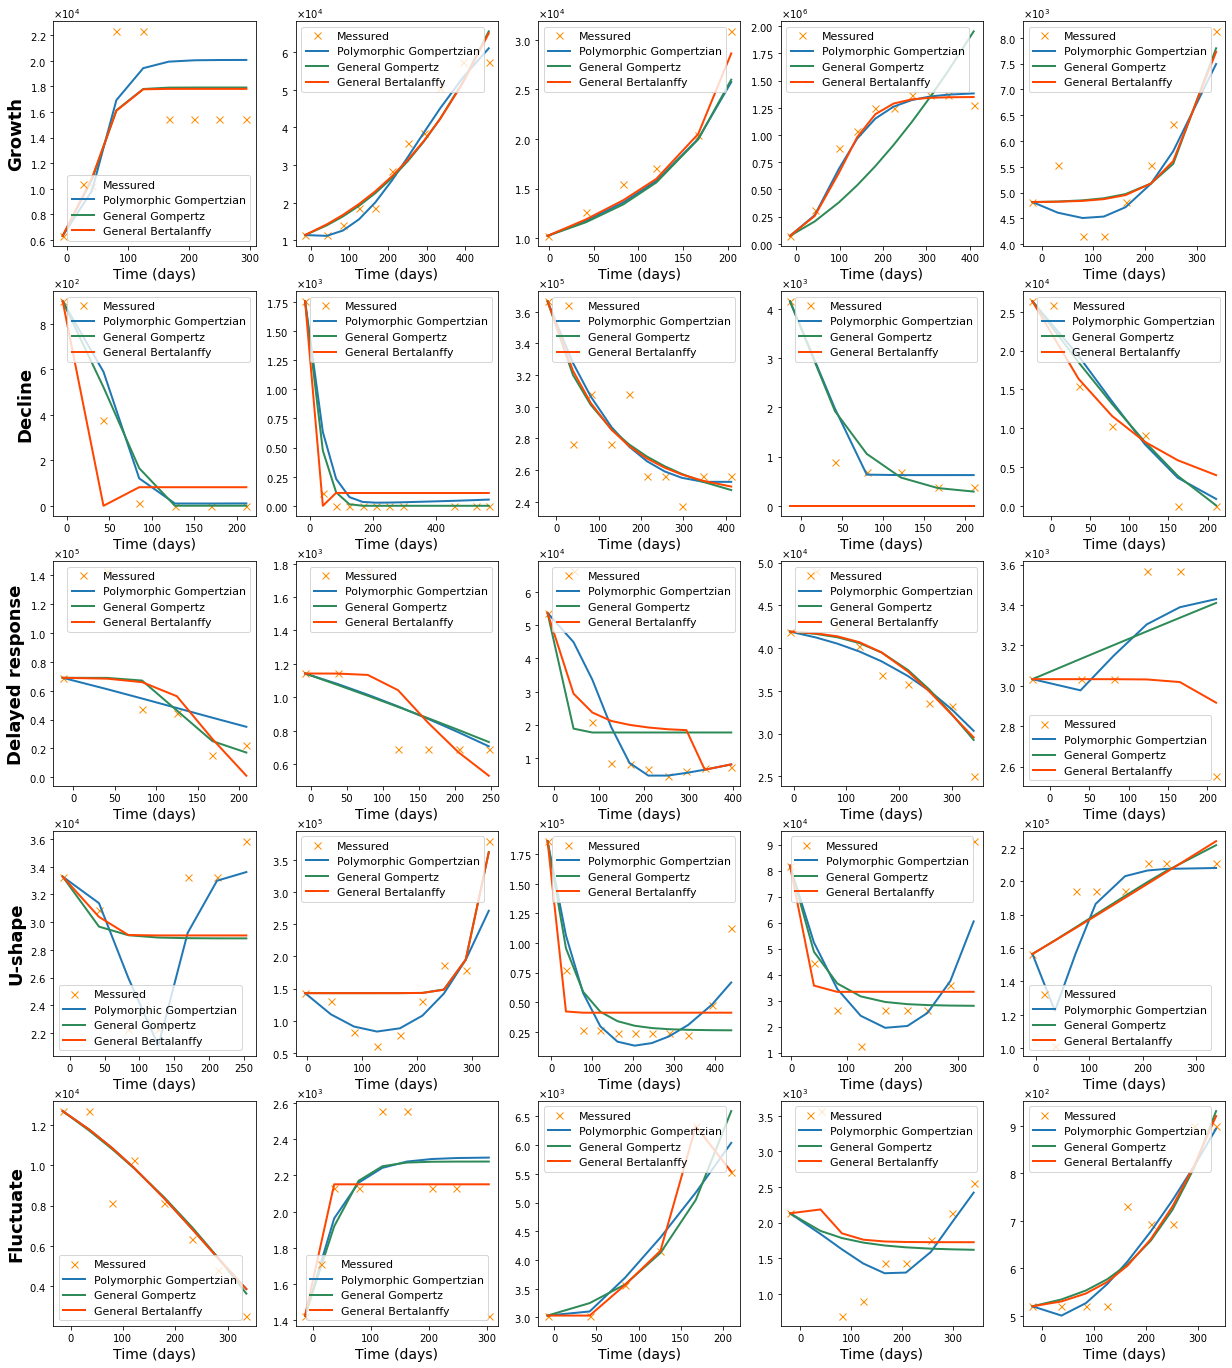

In [71]:
#Visualize dynamics of three models across trend categories
indxs = [indexesMG[:5], indexesMD[5:10], indexesDR[:5], indexesU[1:6], indexesF[10:15]]
indxs = np.array(indxs).flatten()

plt.figure(figsize = (21, 24))
plotSR = True

k = 1
for i in indxs:
    volume = Data_full[i, ~np.isnan(Data_full[i])]
    time = tpoints_full[i, ~np.isnan(tpoints_full[i])]
    
    ax = plt.subplot(5, 5, k)
    ax.plot(time, volume, 'x', markersize = 7, color = 'darkorange', label ='Messured')
    ax.plot(tpoints_full[i], S_full[i]+R_full[i], color = 'tab:blue', linewidth = 2, label = 'Polymorphic Gompertzian')
    ax.plot(tpoints_full[i], VGenGomp_full[i], color = 'seagreen', linewidth = 2, label = 'General Gompertz')
    ax.plot(tpoints_full[i], VGenBer_full[i], color = 'orangered', linewidth = 2, label = 'General Bertalanffy')
    
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True) 
    formatter.set_powerlimits((-1,1)) 
    ax.yaxis.set_major_formatter(formatter) 
    #if (k-1)%5 == 0:    
    ax.legend(fontsize = 11)
    ax.set_xlabel('Time (days)', size = 14)
    #ax.set_ylabel('Tumor volume ($mm^3$)')
    classification = ['Growth', 'Decline', 'Delayed response', 'U-shape', 'Fluctuate']
    if ((k-1)%5 == 0):
        ax.set_ylabel(classification[int((k-1)/5)], weight = 'bold', size = 18)
    k = k+1
    
plt.show()

In [64]:
#Calculate errors
nMSE_GenGomp = np.zeros(587)
MSE_GenGomp = np.zeros(587)
MAE_GenGomp = np.zeros(587)

nMSE_GenBer = np.zeros(587)
MSE_GenBer = np.zeros(587)
MAE_GenBer = np.zeros(587)

for i in range(587):
    nMSE_GenGomp[i] = nmse(Data_full[i, ~np.isnan(Data_full[i])], VGenGomp_full[i, ~np.isnan(Data_full[i])])
    MSE_GenGomp[i] = mean_squared_error(Data_full[i, ~np.isnan(Data_full[i])], VGenGomp_full[i, ~np.isnan(Data_full[i])])
    MAE_GenGomp[i] = mean_absolute_error(Data_full[i, ~np.isnan(Data_full[i])], VGenGomp_full[i, ~np.isnan(Data_full[i])])

    nMSE_GenBer[i] = nmse(Data_full[i, ~np.isnan(Data_full[i])], VGenBer_full[i, ~np.isnan(Data_full[i])])
    MSE_GenBer[i] = mean_squared_error(Data_full[i, ~np.isnan(Data_full[i])], VGenBer_full[i, ~np.isnan(Data_full[i])])
    MAE_GenBer[i] = mean_absolute_error(Data_full[i, ~np.isnan(Data_full[i])], VGenBer_full[i, ~np.isnan(Data_full[i])])

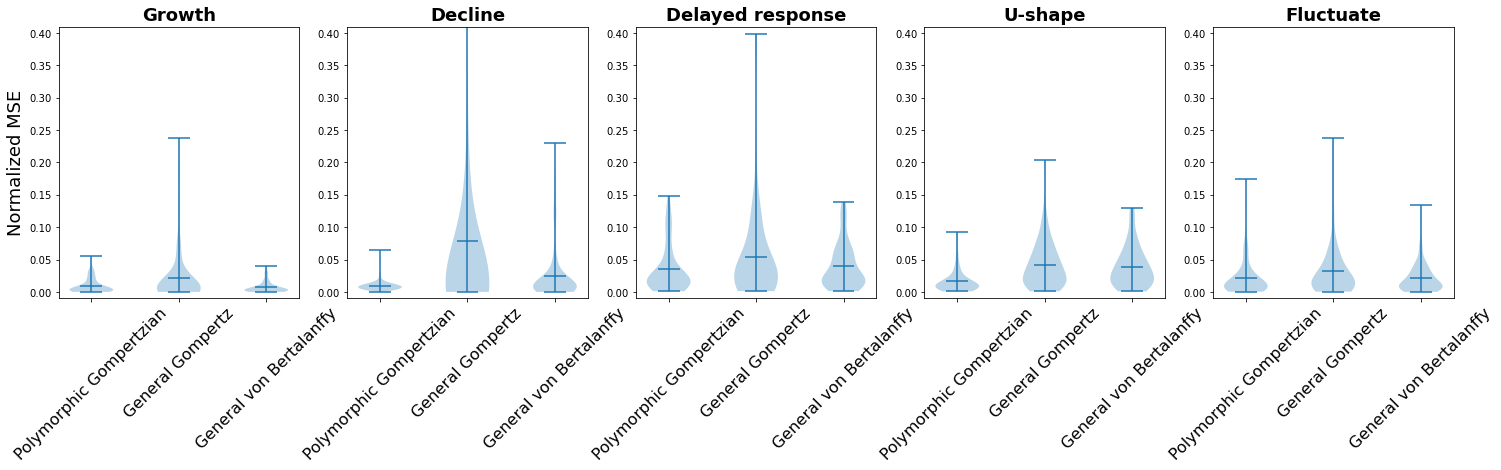

In [85]:
# Errors of the models fits acros trend categories
plt.figure(figsize=(25, 5)) 

ax1 = plt.subplot(1,5,1)
ax1.violinplot([nMSE[indexesMG], nMSE_GenGomp[indexesMG], nMSE_GenBer[indexesMG]][::-1],
               positions =[3,2,1], vert = True, showmeans = True)
ax1.set_xticks([1,2,3]) 
ax1.set_xticklabels(['Polymorphic Gompertzian', 'General Gompertz',
                     'General von Bertalanffy'], rotation = 45, fontsize=16)
ax1.set_title('Growth', weight = 'bold', size = 18)
ax1.set_ylabel('Normalized MSE', size = 18)
ax1.set_ylim([-0.01, 0.41])

ax2 = plt.subplot(1,5,2)
ax2.violinplot([nMSE[indexesMD], nMSE_GenGomp[indexesMD], nMSE_GenBer[indexesMD]][::-1],
               positions =[3,2,1], vert = True, showmeans = True)
ax2.set_xticks([1,2,3]) 
ax2.set_xticklabels(['Polymorphic Gompertzian', 'General Gompertz',
                     'General von Bertalanffy'], rotation = 45, fontsize=16)
ax2.set_title('Decline', weight = 'bold', size = 18)
ax2.set_ylim([-0.01, 0.41])

ax3 = plt.subplot(1,5,3)
ax3.violinplot([nMSE[indexesDR], nMSE_GenGomp[indexesDR], nMSE_GenBer[indexesDR]][::-1],
               positions =[3,2,1], vert = True, showmeans = True)
ax3.set_xticks([1,2,3]) 
ax3.set_xticklabels(['Polymorphic Gompertzian', 'General Gompertz',
                     'General von Bertalanffy'], rotation = 45, fontsize=16)
ax3.set_title('Delayed response', weight = 'bold', size = 18)
ax3.set_ylim([-0.01, 0.41])

ax4 = plt.subplot(1,5,4)
ax4.violinplot([nMSE[indexesU], nMSE_GenGomp[indexesU], nMSE_GenBer[indexesU]][::-1],
               positions =[3,2,1], vert = True, showmeans = True)
ax4.set_xticks([1,2,3]) 
ax4.set_xticklabels(['Polymorphic Gompertzian', 'General Gompertz',
                     'General von Bertalanffy'], rotation = 45, fontsize=16)
ax4.set_title('U-shape', weight = 'bold', size = 18)
ax4.set_ylim([-0.01, 0.41])

ax5 = plt.subplot(1,5,5)
ax5.violinplot([nMSE[indexesF], nMSE_GenGomp[indexesF], nMSE_GenBer[indexesF]][::-1],
               positions =[3,2,1], vert = True, showmeans = True)
ax5.set_xticks([1,2,3]) 
ax5.set_xticklabels(['Polymorphic Gompertzian', 'General Gompertz',
                     'General von Bertalanffy'], rotation = 45, fontsize=16)
ax5.set_title('Fluctuate', weight = 'bold', size = 18)
ax5.set_ylim([-0.01, 0.41])
                
plt.show()

In [ ]:
#T-test
stats.ttest_ind(nMSE[indexesU], nMSE_GenGomp[indexesU], equal_var = False, alternative = "less")

In [ ]:
stats.ttest_ind(nMSE[indexesMD], nMSE_GenBer[indexesMD], equal_var = False, alternative = "less")

In [ ]:
stats.ttest_ind(nMSE[indexesDR], nMSE_GenBer[indexesDR], equal_var = False)

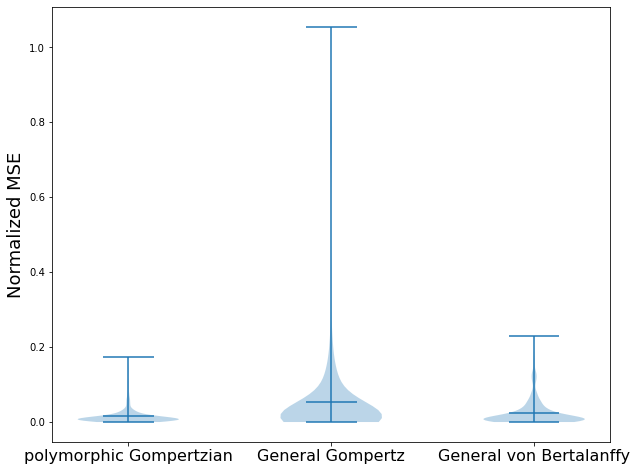

In [68]:
# PLot error distribution across all cases
plt.figure(figsize=(10, 8))
plt.violinplot([nMSE, nMSE_GenGomp, nMSE_GenBer][::-1],
               positions =[3,2,1],vert=True,showmeans=True)
plt.xticks([1,2,3], ['polymorphic Gompertzian', 'General Gompertz',
                     'General von Bertalanffy'], fontsize=16)
plt.ylabel('Normalized MSE', size = 18)

plt.show()